In [1]:
import uproot # for reading .root files
import awkward as ak # to represent nested data in columnar format
import pandas as pd # to store data as dataframe
import vector # for 4-momentum calculations
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import MaxNLocator,AutoMinorLocator # for minor ticks
from lmfit.models import PolynomialModel, GaussianModel # for the signal and background fits

import infofile

In [2]:
lumi = 10
fraction = 1.0
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/"

In [3]:
samples = {

    'data': {
        'list' : ['data_A','data_B','data_C','data_D'],
    },

    r'Background $Z,t\bar{t}$' : { # Z + ttbar
        'list' : ['Zee','Zmumu','ttbar_lep'],
        'color' : "#6b59d3" # purple
    },

    r'Background $ZZ^*$' : { # ZZ
        'list' : ['llll'],
        'color' : "#ff0000" # red
    },

    r'Signal ($m_H$ = 125 GeV)' : { # H -> ZZ -> llll
        'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep','WH125_ZZ4lep','ZH125_ZZ4lep'],
        'color' : "#00cdff" # light blue
    },

}


In [4]:
MeV = 0.001
GeV = 1.0

In [5]:
def calc_weight(xsec_weight, events):
    return (
        xsec_weight
        * events.mcWeight
        * events.scaleFactor_PILEUP
        * events.scaleFactor_ELE
        * events.scaleFactor_MUON 
        * events.scaleFactor_LepTRIGGER
    )

In [6]:
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

In [7]:
def calc_mllll(lep_pt, lep_eta, lep_phi, lep_E):
    # construct awkward 4-vector array
    p4 = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "E": lep_E})
    # calculate invariant mass of first 4 leptons
    # [:, i] selects the i-th lepton in each event
    # .M calculates the invariant mass
    return (p4[:, 0] + p4[:, 1] + p4[:, 2] + p4[:, 3]).M * MeV


In [8]:
def get_data_from_files_CUTS2():

    data = {} # define empty dictionary to hold awkward arrays
    for s in samples: # loop over samples
        print('Processing '+s+' samples') # print which sample
        frames = [] # define empty list to hold data
        for val in samples[s]['list']: # loop over each file
            if s == 'data': prefix = "Data/" # Data prefix
            else: # MC prefix
                prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".4lep.root" # file name to open
            temp = read_file_CUTS2(fileString,val) # call the function read_file defined below
            frames.append(temp) # append array returned from read_file to list of awkward arrays
        data[s] = ak.concatenate(frames) # dictionary entry is concatenated awkward arrays
    
    return data # return dictionary of awkward arrays

In [9]:
def read_file_CUTS2(path,sample):
    start = time.time() # start the clock
    print("\tProcessing: "+sample) # print which sample is being processed
    data_all = [] # define empty list to hold all data for this sample
    with uproot.open(path + ":mini") as tree:
        numevents = tree.num_entries # number of events
        if 'data' not in sample: xsec_weight = get_xsec_weight(sample) # get cross-section weight
        for data in tree.iterate(['lep_pt','lep_eta','lep_phi',
                                  'lep_E','lep_charge','lep_type', 
                                  "lep_ptcone30","lep_etcone20",
                                  'mcWeight','scaleFactor_PILEUP',
                                  'scaleFactor_ELE','scaleFactor_MUON',
                                  'scaleFactor_LepTRIGGER', "jet_n"], # variables to calculate Monte Carlo weight
                                 library="ak", # choose output type as awkward array
                                 entry_stop=numevents*fraction): # process up to numevents*fraction

            nIn = len(data) # number of events in this batch
            if 'data' not in sample: # only do this for Monte Carlo simulation files
                # multiply all Monte Carlo weights and scale factors together to give total weight
                data['totalWeight'] = calc_weight(xsec_weight, data)
            # cut on lepton charge using the function cut_lep_charge defined above
            data = data[~cut_lep_charge(data.lep_charge)]
            # cut on lepton type using the function cut_lep_type defined above
            data = data[~cut_lep_type(data.lep_type)]
            data = data[~cut2_pT_LB(data.lep_pt)]
            data = data[~cut2_ETCone_LB(data.lep_etcone20)]
            data = data[~cut2_ETCone_UB(data.lep_etcone20)]
            data = data[~cut2_eta_UB(data.lep_eta)]

            # calculation of 4-lepton invariant mass using the function calc_mllll defined above
            data['mllll'] = calc_mllll(data.lep_pt, data.lep_eta, data.lep_phi, data.lep_E)

            nOut = len(data) # number of events passing cuts in this batch
            data_all.append(data) # append array from this batch
            elapsed = time.time() - start # time taken to process
            print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
    
    return ak.concatenate(data_all) # return array containing events passing all cuts

In [10]:
def cut_lep_charge(lep_charge):
# throw away when sum of lepton charges is not equal to 0
    num_leptons = ak.count(lep_charge)
    sum_charge = np.sum(lep_charge[:, :num_leptons], axis=1)
    
    return sum_charge != 0
# cut on lepton type
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
    num_leptons = ak.count(lep_type)
    sum_lep_type = np.sum(lep_type[:, :num_leptons], axis = 1)
    return (sum_lep_type != 44) & (sum_lep_type != 48) & (sum_lep_type != 52)

def cut2_ETCone_UB(lep_etcone20):
    num_leptons = ak.count(lep_etcone20)
    sum_etcone20 = np.sum(lep_etcone20[:, :num_leptons], axis=1)

    return 8750 < sum_etcone20

def cut2_eta_UB(lep_eta):
    num_leptons = ak.count(lep_eta)
    sum_eta = np.sum(lep_eta[:, :num_leptons], axis=1)

    return 7 < sum_eta

def cut2_pT_LB(lep_pt):
    num_leptons = ak.count(lep_pt)
    sum_pt = np.sum(lep_pt[:, :num_leptons], axis=1)

    return sum_pt < 83650

def cut2_ETCone_LB(lep_etcone20):
    num_leptons = ak.count(lep_etcone20)
    sum_etcone20 = np.sum(lep_etcone20[:, :num_leptons], axis=1)

    return -5250 > sum_etcone20

In [11]:
data3 = {}
start = time.time() # time at start of whole processing
data3 = get_data_from_files_CUTS2() # process all files
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Processing data samples
	Processing: data_A
		 nIn: 1,	 nOut: 	0	 in 5.0s
		 nIn: 1,	 nOut: 	1	 in 5.1s
		 nIn: 1,	 nOut: 	1	 in 5.1s
		 nIn: 1,	 nOut: 	0	 in 5.2s
		 nIn: 1,	 nOut: 	1	 in 5.2s
		 nIn: 1,	 nOut: 	1	 in 5.3s
		 nIn: 1,	 nOut: 	0	 in 5.4s
		 nIn: 1,	 nOut: 	1	 in 5.4s
		 nIn: 1,	 nOut: 	1	 in 5.5s
		 nIn: 1,	 nOut: 	1	 in 5.5s
		 nIn: 1,	 nOut: 	0	 in 5.6s
		 nIn: 1,	 nOut: 	0	 in 5.6s
		 nIn: 1,	 nOut: 	0	 in 5.7s
		 nIn: 1,	 nOut: 	0	 in 5.7s
		 nIn: 1,	 nOut: 	1	 in 5.8s
		 nIn: 1,	 nOut: 	1	 in 5.8s
		 nIn: 1,	 nOut: 	1	 in 5.9s
		 nIn: 1,	 nOut: 	1	 in 5.9s
		 nIn: 1,	 nOut: 	1	 in 6.0s
		 nIn: 1,	 nOut: 	0	 in 6.0s
		 nIn: 1,	 nOut: 	1	 in 6.1s
		 nIn: 1,	 nOut: 	1	 in 6.1s
		 nIn: 1,	 nOut: 	1	 in 6.2s
		 nIn: 1,	 nOut: 	1	 in 6.3s
		 nIn: 1,	 nOut: 	0	 in 6.3s
		 nIn: 1,	 nOut: 	1	 in 6.4s
		 nIn: 1,	 nOut: 	0	 in 6.4s
		 nIn: 1,	 nOut: 	1	 in 6.5s
		 nIn: 1,	 nOut: 	0	 in 6.5s
		 nIn: 1,	 nOut: 	1	 in 6.6s
		 nIn: 1,	 nOut: 	1	 in 6.6s
		 nIn: 1,	 nOut: 	0	 in 6

In [12]:
def plot_pT(data,min,max,stepsize):
    xmin = min * GeV
    xmax = max * GeV
    step_size = stepsize * GeV
    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values
    signal_x =  ak.to_numpy(ak.sum(data[r'Signal ($m_H$ = 125 GeV)']['lep_pt'], axis = 1))
    signal_weights = ak.to_numpy(data[r'Signal ($m_H$ = 125 GeV)'].totalWeight)
    signal_color = (samples[r'Signal ($m_H$ = 125 GeV)']['color'])
    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars
    for s in samples: # loop over samples
        if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
            mc_x.append(ak.to_numpy( ak.sum(data[s]['lep_pt'], axis = 1)) ) # append to the list of Monte Carlo histogram entries
            mc_weights.append(ak.to_numpy(data[s].totalWeight)) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    data_signal,_ = np.histogram(ak.to_numpy(signal_x),weights= signal_weights, bins=bin_edges )
    data_bkg1,_ = np.histogram(ak.to_numpy(mc_x[0]), weights = mc_weights[0], bins=bin_edges )
    data_bkg2,_ = np.histogram(ak.to_numpy(mc_x[1]), weights = mc_weights[1],  bins=bin_edges )
    
    TotalSigLB = []
    counterSig = 0
    counterBkg1 = 0
    counterBkg2 = 0

    for i in range (len(data_signal)):
        counterSig += data_signal[-i]
        counterBkg1 += data_bkg1[-i]
        counterBkg2 += data_bkg2[-i]
        if (counterSig + counterBkg1 + counterBkg2 == 0):
            binSig = 0
        else:
            binSig = counterSig / np.sqrt(counterBkg1 + counterBkg2 + counterSig)
        TotalSigLB.append(binSig)
    
    TotalSigUB = []
    counterSig = 0
    counterBkg1 = 0
    counterBkg2 = 0

    for i in range (len(data_signal)):
        counterSig += data_signal[i]
        counterBkg1 += data_bkg1[i]
        counterBkg2 += data_bkg2[i]
        binSig = 0
        binSig = counterSig / np.sqrt(counterBkg1 + counterBkg2 + counterSig)
        TotalSigUB.append(binSig)
    
    bin_centres2 = np.flip(bin_centres)
    plt.figure(figsize = (15,10))
    fig, (main_axes,ax2) = plt.subplots(1,2, figsize=(14,7))
    idmax = np.argmax(TotalSigLB)
    muhat = bin_centres2[idmax]
    print(f"LB: {bin_centres2[idmax]:.2f}")
    main_axes.vlines(muhat,np.min(TotalSigLB),np.max(TotalSigLB)*0.99,color='r', label="Best LB cut value")
    idmax2 = np.argmax(TotalSigUB)
    muhat2 = bin_centres[idmax2]
    print(f"UB: {bin_centres[idmax2]:.2f}")
    main_axes.vlines(muhat2,np.min(TotalSigUB),np.max(TotalSigUB)*0.99,color='b', label="Best UB cut value")

    
    main_axes.errorbar(x=bin_centres2, y=(TotalSigLB), yerr=0,markersize= "2",elinewidth=True,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Significance Lower Bound') 
    
    main_axes.errorbar(x=bin_centres, y=(TotalSigUB), yerr=0,markersize= "2",elinewidth=True,
                       fmt='bo', # 'k' means black and 'o' is for circles 
                       label='Significance Upper Bound') 
    

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'Tranverse Momentum [MeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Significance',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0)

    # Add text 'ATLAS' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             '', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.76, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=True ) # no box around the legend

    ax2 = plt.gca() # get current axes

    ax2.hist(signal_x, bins=bin_edges, 
                   weights=signal_weights, color=signal_color,
                   label=r'Signal ($m_H$ = 125 GeV)')
    
    # plot the Monte Carlo bars
    mc_heights = ax2.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=False, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value

    # set the x-limit of the main axes
    ax2.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    ax2.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    ax2.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis

    ax2.set_ylabel('Events / '+str(step_size)+' MeV',
                         y=1, horizontalalignment='right')

    ax2.set_xlabel(r'Tranverse Momentum [MeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    
    # set y-axis limits for main axes
    ax2.set_ylim( bottom=0)
    
    # add minor ticks on y-axis for main axes
    ax2.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # draw the legend
    ax2.legend( frameon=True ) # no box around the legend
    
    return

LB: 77500.00
UB: 52500.00


C:\Users\steph\AppData\Local\Temp\ipykernel_23456\2106881393.py:53: RuntimeWarning: invalid value encountered in double_scalars
  binSig = counterSig / np.sqrt(counterBkg1 + counterBkg2 + counterSig)
c:\Users\steph\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
c:\Users\steph\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\steph\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


<Figure size 1500x1000 with 0 Axes>

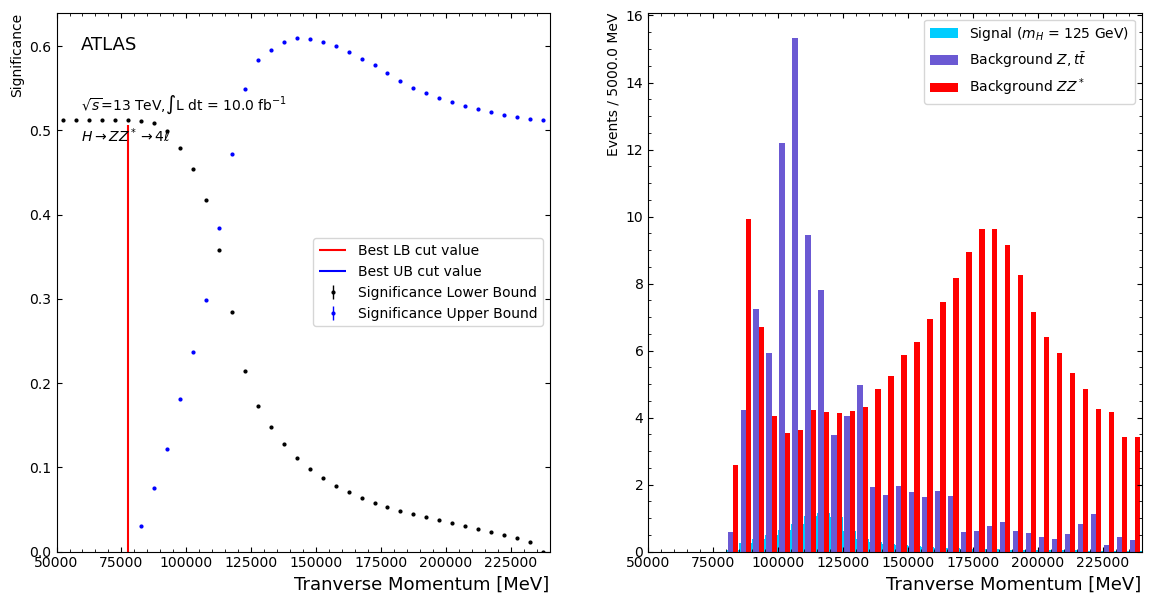

In [13]:
plot_pT(data3,50000,240000,5000)

In [14]:
def plot_etcone20(data,min,max,stepsize):

    xmin = min * GeV
    xmax = max * GeV
    step_size = stepsize * GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    signal_x =  (ak.to_numpy(ak.sum(data[r'Signal ($m_H$ = 125 GeV)']['lep_etcone20'], axis = 1)))
    signal_weights = ak.to_numpy(data[r'Signal ($m_H$ = 125 GeV)'].totalWeight)
    signal_color = (samples[r'Signal ($m_H$ = 125 GeV)']['color'])

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
            mc_x.append( ak.to_numpy(ak.sum(data[s]['lep_etcone20'], axis = 1)) ) # append to the list of Monte Carlo histogram entries
            mc_weights.append(ak.to_numpy(data[s].totalWeight)) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels

    data_signal,_ = np.histogram(ak.to_numpy(signal_x),weights= signal_weights, bins=bin_edges )
    
    data_bkg1,_ = np.histogram(ak.to_numpy(mc_x[0]), weights = mc_weights[0], bins=bin_edges )
    data_bkg2,_ = np.histogram(ak.to_numpy(mc_x[1]), weights = mc_weights[1],  bins=bin_edges )

    # *************
    # Main plot 
    # *************

    TotalSigLB = []
    counterSig = 0
    counterBkg1 = 0
    counterBkg2 = 0


    for i in range (len(data_signal)):
        counterSig += data_signal[-i]
        counterBkg1 += data_bkg1[-i]
        counterBkg2 += data_bkg2[-i]
        if (counterSig + counterBkg1 + counterBkg2 == 0):
            binSig = 0
        else:
            binSig = counterSig / np.sqrt(counterBkg1 + counterBkg2 + counterSig)
        TotalSigLB.append(binSig)


    TotalSigUB = []
    counterSig = 0
    counterBkg1 = 0
    counterBkg2 = 0

    for i in range (len(data_signal)):
        counterSig += data_signal[i]
        counterBkg1 += data_bkg1[i]
        counterBkg2 += data_bkg2[i]
        binSig = 0
        binSig = counterSig / np.sqrt(counterBkg1 + counterBkg2 + counterSig)
        TotalSigUB.append(binSig)

    bin_centres2 = np.flip(bin_centres)

    plt.figure(figsize = (15,10))
    fig, (main_axes,ax2) = plt.subplots(1,2, figsize=(14,7))

    idmax = np.argmax(TotalSigLB)
    muhat = bin_centres2[idmax]
    print(f"LB: {bin_centres2[idmax]:.2f}")
    main_axes.vlines(muhat,np.min(TotalSigLB),np.max(TotalSigLB)*0.99,color='r', label="Best LB cut value")

    idmax2 = np.argmax(TotalSigUB)
    muhat2 = bin_centres[idmax2]
    print(f"UB: {bin_centres[idmax2]:.2f}")
    main_axes.vlines(muhat2,np.min(TotalSigUB),np.max(TotalSigUB)*0.99,color='b', label="Best UB cut value")


    
    main_axes.errorbar(x=bin_centres2, y=(TotalSigLB), yerr=0,markersize= "2",elinewidth=True,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Significance Lower Bound') 
    
    main_axes.errorbar(x=bin_centres, y=(TotalSigUB), yerr=0,markersize= "2",elinewidth=True,
                       fmt='bo', # 'k' means black and 'o' is for circles 
                       label='Significance Upper Bound')
    

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'ET cone 20 [MeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Significance',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top= np.max(TotalSigUB) * 1.6 )

    # Add text 'ATLAS' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             '', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.76, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=True ) # no box around the legend

    ax2 = plt.gca() # get current axes

    # plot the signal bar
    ax2.hist(signal_x, bins=bin_edges, 
                   weights=signal_weights, color=signal_color,
                   label=r'Signal ($m_H$ = 125 GeV)')
    
    # plot the Monte Carlo bars
    mc_heights = ax2.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=False, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value

    

    # set the x-limit of the main axes
    ax2.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    ax2.xaxis.set_minor_locator( AutoMinorLocator() ) 

    ax2.set_ylabel('Events / '+str(step_size)+' MeV',
                         y=1, horizontalalignment='right')
    
    # set the axis tick parameters for the main axes
    ax2.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    
    # set y-axis limits for main axes
    ax2.set_ylim( bottom=0)
    
    # add minor ticks on y-axis for main axes
    ax2.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # draw the legend
    ax2.legend( frameon=True ) # no box around the legend
    
    return

LB: -5000.00
UB: 8000.00


<Figure size 1500x1000 with 0 Axes>

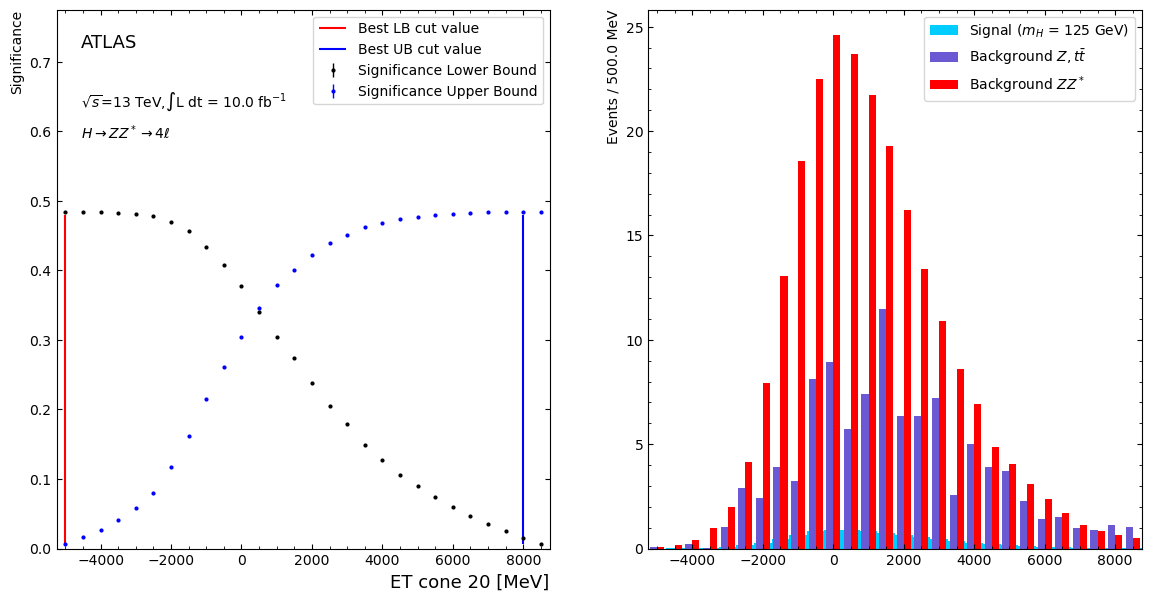

In [15]:
plot_etcone20(data3,-5250,8750,500)

In [16]:
def plot_eta(data,min,max,stepsize):

    xmin = min * GeV
    xmax = max * GeV
    step_size = stepsize * GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    signal_x =  (ak.to_numpy(ak.sum(data[r'Signal ($m_H$ = 125 GeV)']['lep_eta'], axis = 1)))
    signal_weights = ak.to_numpy(data[r'Signal ($m_H$ = 125 GeV)'].totalWeight)
    signal_color = (samples[r'Signal ($m_H$ = 125 GeV)']['color'])

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
            mc_x.append( ak.to_numpy(ak.sum(data[s]['lep_eta'], axis = 1)) ) # append to the list of Monte Carlo histogram entries
            mc_weights.append(ak.to_numpy(data[s].totalWeight)) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels

    data_signal,_ = np.histogram(ak.to_numpy(signal_x),weights= signal_weights, bins=bin_edges )
    
    data_bkg1,_ = np.histogram(ak.to_numpy(mc_x[0]), weights = mc_weights[0], bins=bin_edges )
    data_bkg2,_ = np.histogram(ak.to_numpy(mc_x[1]), weights = mc_weights[1],  bins=bin_edges )

    # *************
    # Main plot 
    # *************
    
    TotalSigLB = []
    counterSig = 0
    counterBkg1 = 0
    counterBkg2 = 0


    for i in range (len(data_signal)):
        counterSig += data_signal[-i]
        counterBkg1 += data_bkg1[-i]
        counterBkg2 += data_bkg2[-i]
        if (counterSig + counterBkg1 + counterBkg2 == 0):
            binSig = 0
        else:
            binSig = counterSig / np.sqrt(counterBkg1 + counterBkg2 + counterSig)
        TotalSigLB.append(binSig)


    TotalSigUB = []
    counterSig = 0
    counterBkg1 = 0
    counterBkg2 = 0

    for i in range (len(data_signal)):
        counterSig += data_signal[i]
        counterBkg1 += data_bkg1[i]
        counterBkg2 += data_bkg2[i]
        binSig = 0
        binSig = counterSig / np.sqrt(counterBkg1 + counterBkg2 + counterSig)
        TotalSigUB.append(binSig)

    bin_centres2 = np.flip(bin_centres)

    plt.figure(figsize = (15,10))
    fig, (main_axes,ax2) = plt.subplots(1,2, figsize=(14,7))

    idmax = np.argmax(TotalSigLB)
    muhat = bin_centres2[idmax]
    print(f"LB: {bin_centres2[idmax]:.2f}")
    main_axes.vlines(muhat,np.min(TotalSigLB),np.max(TotalSigLB)*0.99,color='r', label="Best LB cut value")

    idmax2 = np.argmax(TotalSigUB)
    muhat2 = bin_centres[idmax2]
    print(f"UB: {bin_centres[idmax2]:.2f}")
    main_axes.vlines(muhat2,np.min(TotalSigUB),np.max(TotalSigUB)*0.99,color='b', label="Best UB cut value")


    main_axes.errorbar(x=bin_centres2, y=(TotalSigLB), yerr=0,markersize= "2",elinewidth=True,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Significance Lower Bound') 
    
    main_axes.errorbar(x=bin_centres, y=(TotalSigUB), yerr=0,markersize= "2",elinewidth=True,
                       fmt='bo', # 'k' means black and 'o' is for circles 
                       label='Significance Upper Bound')
    

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'Eta',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Significance',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top= np.max(TotalSigUB) * 1.6 )

    # Add text 'ATLAS' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             '', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.76, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=True ) # no box around the legend

    ax2 = plt.gca() # get current axes
    
    # plot the signal bar
    ax2.hist(signal_x, bins=bin_edges, 
                   weights=signal_weights, color=signal_color,
                   label=r'Signal ($m_H$ = 125 GeV)')


    # plot the Monte Carlo bars
    mc_heights = ax2.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=False, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value

    
    # set the x-limit of the main axes
    ax2.set_xlim( left=xmin, right=xmax ) 

    ax2.set_ylabel('Events / '+str(step_size)+' MeV',
                         y=1, horizontalalignment='right')
    
    # separation of x axis minor ticks
    ax2.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    ax2.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    
    # set y-axis limits for main axes
    ax2.set_ylim( bottom=0)
    
    # add minor ticks on y-axis for main axes
    ax2.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # draw the legend
    ax2.legend( frameon=True ) # no box around the legend
    
    return

LB: -11.00
UB: 7.00


<Figure size 1500x1000 with 0 Axes>

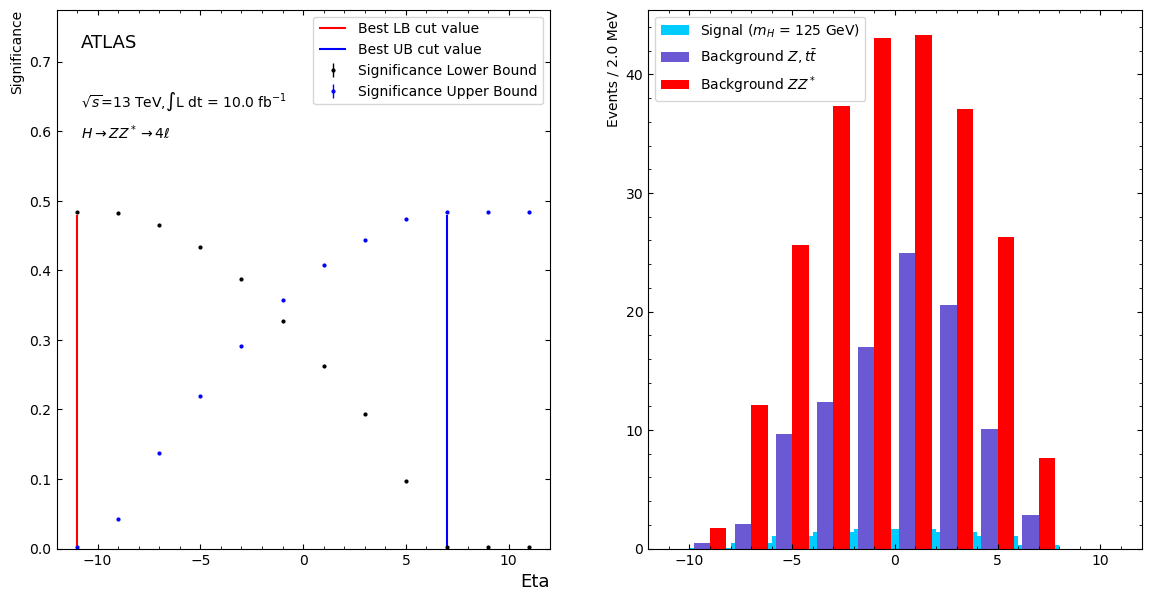

In [17]:
plot_eta(data3,-12,12,2)

In [18]:
def plot_Mass(data,min,max,stepsize):

    xmin = min * GeV
    xmax = max * GeV
    step_size = stepsize * GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(ak.to_numpy(data['data']['mllll']), 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    signal_x = ak.to_numpy(data[r'Signal ($m_H$ = 125 GeV)']['mllll']) # histogram the signal
    signal_weights = ak.to_numpy(data[r'Signal ($m_H$ = 125 GeV)'].totalWeight) # get the weights of the signal events
    signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
            mc_x.append( ak.to_numpy(data[s]['mllll']) ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( ak.to_numpy(data[s].totalWeight) ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,markersize= "2",elinewidth=True,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])
    
    # plot the signal bar
    main_axes.hist(signal_x , bins=bin_edges, bottom=mc_x_tot, 
                   weights=(signal_weights), color=signal_color,
                   label=r'Signal ($m_H$ = 125 GeV)')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # Add text 'ATLAS' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             '', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.76, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=True ) # no box around the legend
    
    return

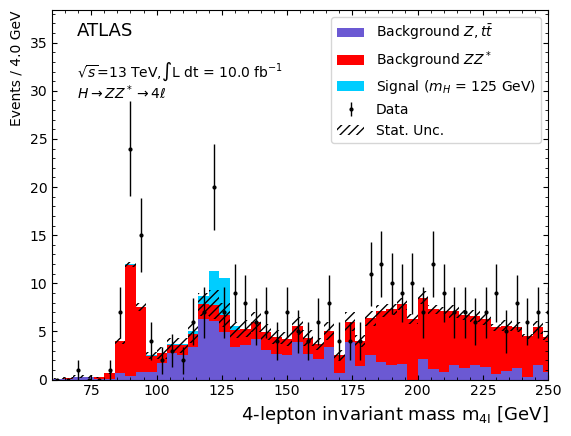

In [19]:
plot_Mass(data3,60,250,4)

In [20]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
import math

# The likelihood is given by the product of the poisson probability function for each bin
# Each poisson term represents the probability of observing N_i events in data, given the μ*S_i+B_i expectation
# In the above S_i and B_i are respectively the number of signal and background expected events in the bin i

def likelihood(N,mu,S,B,verbose=False):

  likelihood = 1
  for i in range(len(N)):
    p_i = scipy.stats.poisson.pmf(N[i],mu*S[i]+B[i])
    likelihood *= p_i
    #if verbose:
      #print(f'bin {i} data {N[i]} expected data {mu*S[i]+B[i]} poisson probability {p_i}')

  return likelihood

In [21]:
def significance(S,B,verbose=False):
  if verbose:
    print(f'Number of events for signal {S} and background {B}')
  return S/math.sqrt(S+B)

In [22]:
def LikelihoodValue(data,min,max,stepsize):
    xmin = min * GeV
    xmax = max * GeV
    step_size = stepsize * GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                        stop=xmax+step_size, # The interval doesn't include this value
                        step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    signal_x =  (data[r'Signal ($m_H$ = 125 GeV)']['mllll'])
    signal_weights = (ak.to_numpy(data[r'Signal ($m_H$ = 125 GeV)'].totalWeight))
    data_signal,_ = np.histogram(ak.to_numpy(signal_x),weights= signal_weights, bins=bin_edges )

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
            mc_x.append(data[s]['mllll'])# append to the list of Monte Carlo histogram entries
            mc_weights.append(ak.to_numpy(data[s].totalWeight)) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels

    data_bkg1,_ = np.histogram(ak.to_numpy(mc_x[0]), weights = mc_weights[0], bins=bin_edges )
    data_bkg2,_ = np.histogram(ak.to_numpy(mc_x[1]), weights = mc_weights[1],  bins=bin_edges )

    data_x,_ = np.histogram(ak.to_numpy(data['data']['mllll']), 
                                bins=bin_edges ) # histogram the data

    # Real data measurement: 
    N = data_x

    # Expected signal:  
    S = data_signal

    # Expected background:  
    B = data_bkg1 + data_bkg2

    # assuming that the normalisation of the simulation is correct means μ = 1
    mu = 1

    print (f'The likelihood value is {likelihood(N,mu,S,B,verbose=True)}')

    mus = np.arange(0,10,0.05)
    loglikelihood=np.zeros_like(mus)

    for i in range(len(mus)):
        loglikelihood[i] = math.log10(likelihood(N,mus[i],S,B))


    # The best fit value of μ is the one that maximises the (log)likelihood
    idmax = np.argmax(loglikelihood)
    muhat = mus[idmax]
    halflog = np.max(loglikelihood)-(0.5*np.abs(np.max(loglikelihood)))

    plt.plot(mus,loglikelihood,'-', label = "Function")
    plt.vlines(muhat,np.min(loglikelihood),np.max(loglikelihood)*0.99,color='r', label="Best fit value")
    plt.hlines(halflog,np.min(mus),np.max(mus),color='g',linestyle = "dashed",label="Uncertainty interval")
    plt.xlabel('Signal Strength Constant, $\mu$')
    plt.ylabel('Log(Likelihood)')
    plt.title("")
    plt.legend(loc = "upper right")
    plt.tick_params(which='both', # ticks on both x and y axes
                        direction='in', # Put ticks inside and outside the axes
                        top=True, # draw ticks on the top axis
                        labelbottom=True, # don't draw tick labels on bottom axis
                        right=True ) # draw ticks on right axis
    plt.show()

    # indices of the log-likelihood array sorted by values closest to the half log-likelihood
    indices = (np.abs(loglikelihood - halflog)).argsort()

    # mu values corresponding to the half log-likelihood
    mu_1 = mus[indices[0]] # 1st sorted index has the closest value
    mu_2 = mus[indices[1]] # 2nd sorted index has the second closest value

    mu_interval = [mu_1, mu_2]
    mu_interval.sort()

    mu_do, mu_up = mu_interval[0], mu_interval[1]

    print(f'The best-fit value of mu is {muhat} and the uncertainty interval is μ<[{mu_do:.2f}]')
    
    totS = S.sum()
    totB = B.sum()
    totN = N.sum()

    print(f'The expected significance is Z={significance(totS,totB,verbose=True):.2f}')

    # The observed signal is the signal theoretical expectation scaled by the signal strength
    obsS = N.sum()-B.sum()

    print(f'The observed significance is Z={significance(obsS,totB,verbose=True):.2f}')

    print (f'For best fit mu the likelihood value is {likelihood(N,muhat,S,B,verbose=True)}')
    print(f"Num of data: {N.sum():.2f}")

    q = -2 * (math.log10(likelihood(N,0,S,B,verbose=True) / likelihood(N,muhat,S,B,verbose=True)))
    ExpSig = np.sqrt(np.abs(q))

    print(f"ExpSig: {ExpSig:.2f}")

    RealSig = (muhat * totS) / np.sqrt(totN)

    print(f"RealSig: {RealSig:.2f}")


The likelihood value is 6.156043119515039e-18


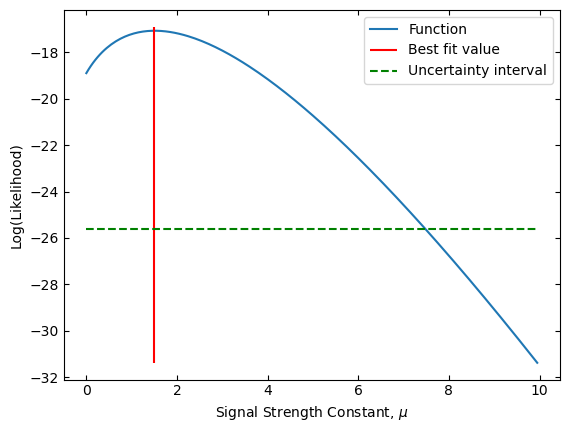

The best-fit value of mu is 1.5 and the uncertainty interval is μ<[7.45]
Number of events for signal 8.776337623596191 and background 34.13425827026367
The expected significance is Z=1.34
Number of events for signal 15.865741729736328 and background 34.13425827026367
The observed significance is Z=2.24
For best fit mu the likelihood value is 8.603033821510122e-18
Num of data: 50.00
ExpSig: 1.91
RealSig: 1.86


In [23]:
LikelihoodValue(data3,110,132,1)

In [24]:
def plot_MassSignalStrength(data,min,max,stepsize,signalstrength):

    xmin = min * GeV
    xmax = max * GeV
    step_size = stepsize * GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(ak.to_numpy(data['data']['mllll']), 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    signal_x = ak.to_numpy(data[r'Signal ($m_H$ = 125 GeV)']['mllll']) # histogram the signal
    signal_weights = ak.to_numpy((data[r'Signal ($m_H$ = 125 GeV)'].totalWeight)* signalstrength) # get the weights of the signal events
    signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
            mc_x.append( ak.to_numpy(data[s]['mllll']) ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( ak.to_numpy(data[s].totalWeight) ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,markersize= "2",elinewidth=True,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])
    
    # plot the signal bar
    main_axes.hist(signal_x , bins=bin_edges, bottom=mc_x_tot, 
                   weights=(signal_weights), color=signal_color,
                   label=r'Signal ($m_H$ = 125 GeV)')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # Add text 'ATLAS' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             '', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.76, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=True ) # no box around the legend
    
    return

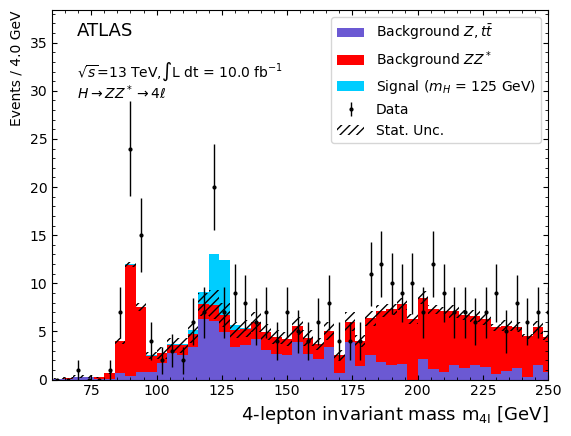

In [25]:
plot_MassSignalStrength(data3,60,250,4,1.5)

In [26]:
import scipy.optimize as optimization
from scipy.optimize import curve_fit
import scipy.stats as stats

def plot_linear(data,min,max,stepsize):   

    xmin = min # GeV
    xmax = max # GeV
    step_size = stepsize # GeV
    
    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(ak.to_numpy(data["data"]["mllll"]), 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    # data fit
    polynomial_mod = PolynomialModel( 1 ) # Straight line fit
    gaussian_mod = GaussianModel() # Gaussian

    pars = polynomial_mod.guess(data_x, # data to use to guess parameter values
                                x=bin_centres, c0= data_x.max(), c1=0,)
    
    # set initial guesses for the parameters of the Gaussian model
    pars += gaussian_mod.guess(data_x, # data to use to guess parameter values
                               x=bin_centres, amplitude=100, 
                               center=125, sigma=2 )
    
    model = polynomial_mod + gaussian_mod # combined model

    weights = []

    for i in range (len(data_x)):
        if data_x_errors[i] == 0:
            weights.append(0.1)
        else:
            weights.append(1/data_x_errors[i])
    
    out = model.fit(data_x, # data to be fit
                    pars, # guesses for the parameters
                    x=bin_centres, weights=weights )  

    # background part of fit
    params_dict = out.params.valuesdict() # get the parameters from the fit to data
    c0 = params_dict['c0'] # c0 of c0 + c1*x 
    c1 = params_dict['c1'] # c1 of c0 + c1*x 

    background = c0 + c1*bin_centres

    # data fit - background fit = signal fit
    signal_x = data_x - background 

    print(c0)
    print(c1)
    cen = params_dict['center'] 
    amp = params_dict['amplitude'] 
    height = params_dict['height'] 
    sigma = params_dict['sigma']

    print(f"center: {cen}")
    print(f"ampltiude: {amp}")
    print(f"width: {height}")
    print(f"sigma: {sigma}")
    # *************
    # Main plot 
    # *************
    plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height 
    main_axes = plt.gca() # get current axes

    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,markersize= "4",elinewidth=True, 
                       fmt='ko', # 'k' means black and 'o' means circles
                       label='Data' ) 

    # plot the background only fit
    main_axes.plot(bin_centres, # x
                   background, # y
                   '--b', # dashed red line
                   label='Bkg (Linear Fit)' )
    
    # plot the signal + background fit
    main_axes.plot(bin_centres, # x
                   out.best_fit, # y
                   '-r', # single red line
                   label='Sig+Bkg Fit ($m_H=125$ GeV)' )
    

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x-axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          labelbottom=False, # don't draw tick labels on bottom axis
                          right=True ) # draw ticks on right axis
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV', 
                         horizontalalignment='right') 
    
    # set the y-axis limit for the main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.1 ) 
    
    # set minor ticks on the y-axis of the main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.92, # y
             'ATLAS', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    plt.text(0.05, # x
             0.86, # y
             "$\sqrt{s}$=13 TeV",
             transform=main_axes.transAxes )
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.8, # y
             '$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes 
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.74, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend(frameon=False, # no box around the legend
                     loc='upper right' ) # legend location 


    # *************
    # Data-Bkg plot 
    # *************
    plt.axes([0.1,0.1,0.85,0.2]) # left, bottom, width, height
    sub_axes = plt.gca() # get the current axes
    
    # set the y axis to be symmetric about Data-Background=0
    sub_axes.yaxis.set_major_locator( MaxNLocator(nbins='auto', 
                                                  symmetric=True) )
    
    # plot Data-Background
    sub_axes.errorbar(x=bin_centres, y=signal_x, yerr=data_x_errors,markersize= "4",elinewidth=True,
                      fmt='ko' ) # 'k' means black and 'o' means circles
    
    # draw the background only fit
    sub_axes.plot(bin_centres, # x
                  background-background, # y
                  '--b' )  # dashed red line

    # draw the fit to data
    sub_axes.plot(bin_centres, # x
                  out.best_fit-background, # y
                  '-r' ) # single red line
    
    
    # set the x-axis limits on the sub axes
    sub_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x-axis minor ticks
    sub_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # x-axis label
    sub_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                        x=1, horizontalalignment='right', 
                        fontsize=13 ) 
    
    # set the tick parameters for the sub axes
    sub_axes.tick_params(which='both', # ticks on both x and y axes
                         direction='in', # Put ticks inside and outside the axes
                         top=True, # draw ticks on the top axis
                         right=True ) # draw ticks on right axis 
    
    # separation of y-axis minor ticks
    sub_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # y-axis label on the sub axes
    sub_axes.set_ylabel( 'Events-Bkg' ) 


    # Generic features for both plots
    main_axes.yaxis.set_label_coords( -0.09, 1 ) # x,y coordinates of the y-axis label on the main axes
    sub_axes.yaxis.set_label_coords( -0.09, 0.5 ) # x,y coordinates of the y-axis label on the sub axes
    
    return

-2.917175705319629
0.05307836071646565
center: 125.35802177568291
ampltiude: 112.05590979621886
width: 8.208909454354337
sigma: 5.445771243721362


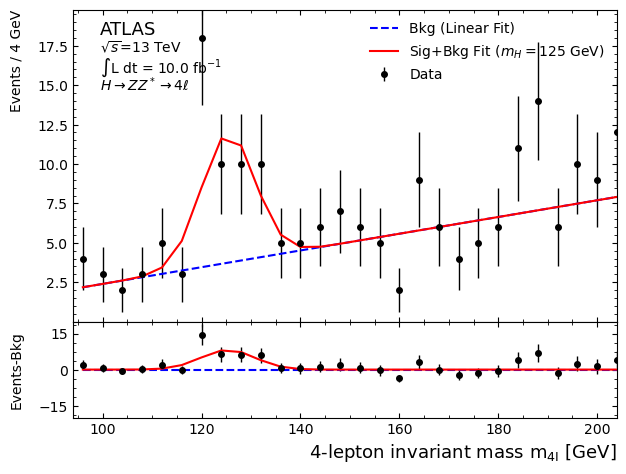

In [27]:
plot_linear(data3,94,204,4)